In [1]:
import sys
#in case of python2
from __future__ import division
import numpy as np

#setup the notebook
from IPython.display import display, Image
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

mpl.rcParams['axes.facecolor'] = 'FFFFFF'
mpl.rcParams['figure.facecolor'] = 'FFFFFF'
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['savefig.dpi'] = 92
mpl.rcParams['figure.figsize'] = [7.0, 3.0]

import sympy
print("Sympy version: ", sympy.__version__)
sympy.init_printing(use_latex=True)

Populating the interactive namespace from numpy and matplotlib
Sympy version:  1.0


In [2]:
#for later thermal noise calculations
k_boltzman = 1.38064852e-23 #J/K
temp_K = 300

subsman = {}

Mtm_kg = sympy.var('M_TM', real = True)
#make the pum the same as testmass, but semantic naming for clarity
Mpum_kg = Mtm_kg

#frequency of evaluation
F = sympy.var('F', real = True)

#variables for fiber mode
F_vio_Hz = sympy.var('F_vio', real = True)
M_fiber_kg = sympy.var('M_fiber', real = True)
k_fiber_N_m_val = (sympy.pi * 2 * F_vio)**2 * M_fiber
k_fiber_N_m = sympy.var('k_fiber', real = True)
subsman[k_fiber_N_m] = k_fiber_N_m_val

detune_F_D_Hz = sympy.var('F_Delta', real = True)
loss_fiber = 1e-9

#variables for damper mode
loss_D = sympy.var('theta_D', real = True)
M_D_kg = sympy.var('M_D', real = True)
k_D_N_m_val = (sympy.pi * 2 * (F_vio_Hz + detune_F_D_Hz))**2 * (M_D_kg * Mpum_kg) / (M_D_kg + Mpum_kg) / (1 + 2 * loss_D**2)**.5
k_D_N_m = sympy.var('k_D_N_m', real = True)
subsman[k_D_N_m] = k_D_N_m_val

#variables for pendulum mode
F_pend_Hz = sympy.var('F_pend', real = True)
#here we use the reduced mass between TM and PUM
k_pend_N_m = (sympy.pi * 2 * F_pend_Hz)**2 * Mtm_kg/2
k_pend_TMadj_N_m = k_pend_N_m - k_fiber_N_m

#for the PUM resonance, lower the frequency by 2x
k_pendPUM_N_m_val = (sympy.pi * 2 * F_pend_Hz/2)**2 * Mtm_kg
k_pendPUM_N_m = sympy.var('k_pendPUM')
subsman[k_pendPUM_N_m] = k_pendPUM_N_m_val

loss_pend = 1e-9


def Zseries(*args):
    return sum(args)

#sympy wont simplify the universal expression in the final "else" clause, so for args up to 3 I
#presimplify to help sympy along
def Zparallel(*args):
    if len(args) == 1:
        return args[0]
    elif len(args) == 2:
        a, b = args
        return a*b / (a + b)
    elif len(args) == 3:
        a, b, c = args
        return a*b*c / (a*b + b*c + a*c)
    else:
        s = 1/args[0]
        for v in args[1:]:
            s = s + 1/v
        return 1/s

def Zspring(k_N_m, loss = 0):
    return sympy.I * 2 * sympy.pi * F/ (k_N_m * (1 + sympy.I * loss))

def Zmass(m_kg):
    return 1/(sympy.I * 2 * sympy.pi * F * m_kg)

def logspaced(lower, upper, n_points):
    'helper to generate samplings for plots'
    log_lower = np.log(lower)
    log_upper = np.log(upper)
    return np.exp(np.linspace(log_lower, log_upper, n_points))

In [3]:
M_fiber_kg_true =  (205e-4**2 * np.pi * 1e2 * 2.2e-3) / 2 #divide by two for the harmonic mode
M_fiber_kg_true

In [4]:
k_D_N_m

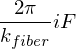

In [5]:
Zspring(k_fiber_N_m)

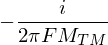

In [6]:
Zmass(Mtm_kg)

In [8]:
xp_vec = sympy.Matrix([sympy.var('x_1, p_1, x_2, p_2, x_3, p_3, x_4, p_4')]).T
display(xp_vec.T)

t = sympy.var('t')
xp_vecdt = sympy.Matrix([sympy.Derivative(v, t) for v in xp_vec])
display(xp_vecdt.T)

xp_vecdt = sympy.Matrix([sympy.Symbol('\dot{{{0}}}'.format(v)) for v in 'x_1, p_1, x_2, p_2, x_3, p_3, x_4, p_4'.split(',')])
xp_vecdt.T

#inject number value pairs for vectors
def arr_gen(*args):
    vec = [0] * 8
    for num, val in zip(args[::2], args[1::2]):
        vec[num] = val
    return vec

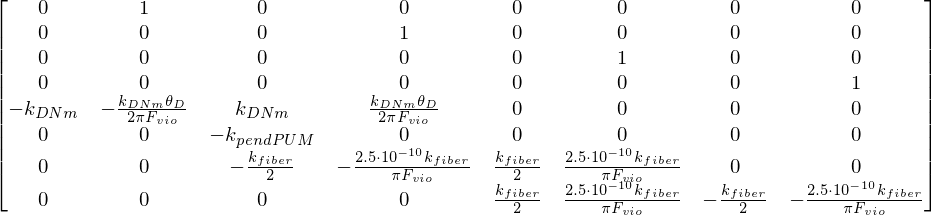

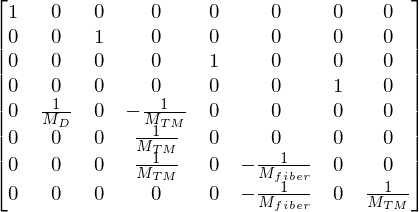

In [9]:
SS_lst  = []
SSd_lst = []

SS_lst.append(arr_gen(1, 1))
SSd_lst.append(arr_gen(0, 1))
SS_lst.append(arr_gen(3, 1))
SSd_lst.append(arr_gen(2, 1))
SS_lst.append(arr_gen(5, 1))
SSd_lst.append(arr_gen(4, 1))
SS_lst.append(arr_gen(7, 1))
SSd_lst.append(arr_gen(6, 1))

#spring 1-2
SS_lst.append(arr_gen(
    0, -k_D_N_m, 
    2, +k_D_N_m,
    1, -k_D_N_m * loss_D / (2 * sympy.pi * F_vio_Hz), 
    3, +k_D_N_m * loss_D / (2 * sympy.pi * F_vio_Hz),
))
SSd_lst.append(arr_gen(
    1, 1/M_D_kg, 
    3, - 1/Mpum_kg,
))

#spring 2-wall
SS_lst.append(arr_gen(
    2, 1 * - k_pendPUM, 
))
SSd_lst.append(arr_gen(
    3, 1/Mpum_kg,
))

#spring 2-3
SS_lst.append(arr_gen(
    2, 1 * - k_fiber_N_m / 2, 
    4, 1 * + k_fiber_N_m / 2, 
    3, 1 * - k_fiber_N_m / 2 * loss_fiber / (2 * sympy.pi * F_vio_Hz), 
    5, 1 * + k_fiber_N_m / 2 * loss_fiber / (2 * sympy.pi * F_vio_Hz),
))
SSd_lst.append(arr_gen(
    3, 1/Mpum_kg, 
    5, - 1/M_fiber_kg,
))
#spring 4-3
SS_lst.append(arr_gen(
    6, 1 * - k_fiber_N_m / 2, 
    4, 1 * + k_fiber_N_m / 2, 
    7, 1 * - k_fiber_N_m / 2 * loss_fiber / (2 * sympy.pi * F_vio_Hz), 
    5, 1 * + k_fiber_N_m / 2 * loss_fiber / (2 * sympy.pi * F_vio_Hz),
))
SSd_lst.append(arr_gen(
    7, 1/Mtm_kg, 
    5, - 1/M_fiber_kg,
))


SS = sympy.Matrix(SS_lst)
display(SS)
SSd = sympy.Matrix(SSd_lst)
display(SSd)

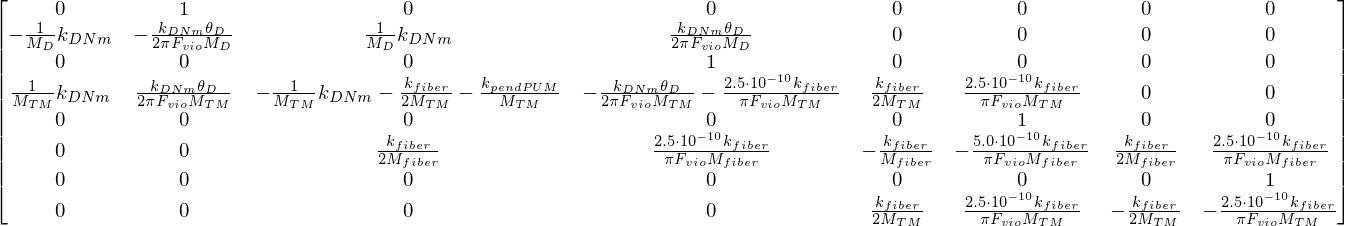

In [10]:
SS_full = SSd.T * SS
SS_full

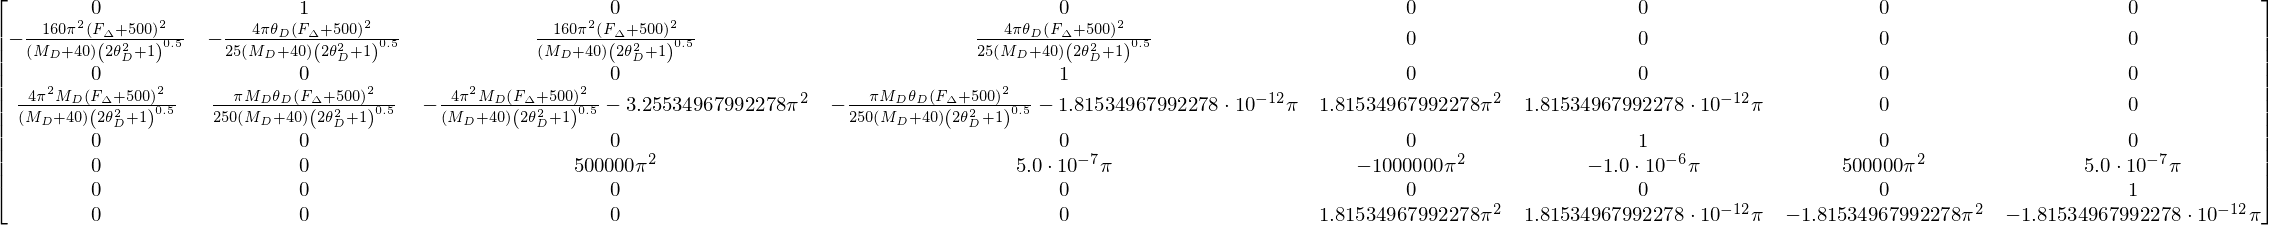

In [11]:
SS_subst = SS_full.subs(subsman).subs({
        Mtm_kg: 40,
        M_fiber_kg: M_fiber_kg_true,
        F_vio_Hz: 500,
        F_pend_Hz : 1.2,
    })
SS_subst

In [12]:

SS_subst_full = SS_subst.subs({
    loss_D: 1e-2, 
    M_D: .01,
    detune_F_D_Hz : 0,
})
model = np.array(SS_subst_full.evalf().n())
model = np.matrix([[float(x) for x in x1] for x1 in model], dtype=float)


eig, eigv = np.linalg.eig(model)

freqs = []
Qs = []
xDs = []
pDs = []
xFs = []
pFs = []
xPUs = []
pPUs = []
for idx in range(8):
    F = eig[idx].imag / (2 * np.pi)
    if abs(F) > .1:
        freqs.append(F)
        Q =  1/(eig[idx].real / eig[idx].imag) / 2
        Qs.append(Q)
        xDs.append(eigv[0,idx])
        pDs.append(eigv[1,idx])
        xPUs.append(eigv[2,idx])
        pPUs.append(eigv[3,idx])
        xFs.append(eigv[4,idx])
        pFs.append(eigv[5,idx])
    
import tabulate
def pclpx(lst):
    return [abs(x) if x.imag != 0 else x.real for x in lst]
print(tabulate.tabulate(np.array([
    pclpx(freqs), 
    pclpx(Qs), 
    pclpx(xDs), 
    pclpx(pDs), 
    pclpx(xFs), 
    pclpx(pFs),
    pclpx(xPUs), 
    pclpx(pPUs),
]).T, headers = 'freqs, Qs, xDs, pDs, xFs, pFs, xPUs, pPUs'.split(',')))

      freqs              Qs          xDs          pDs          xFs        pFs         xPUs         pPUs
-----------  --------------  -----------  -----------  -----------  ---------  -----------  -----------
 499.969     -100.004        0.000318301  -0.999922    3.97896e-06  0.0124997  7.95753e-08  0.000249981
-499.969      100.004        0.000318301  -0.999922    3.97896e-06  0.0124997  7.95753e-08  0.000249981
 500           -4.22186e+07  5.77699e-08   0.00018149  0.00031831   1          5.78027e-10  1.81593e-06
-500            4.22186e+07  5.77699e-08   0.00018149  0.00031831   1          5.78027e-10  1.81593e-06
   0.834517    -1.02124e+12  0.123518      0.64766     0.0319097    0.167316   0.123518     0.647658
  -0.834517     1.02124e+12  0.123518      0.64766     0.0319097    0.167316   0.123518     0.647658
   0.342449    -3.4832e+12   0.143396      0.308542    0.22008      0.473541   0.143396     0.308542
  -0.342449     3.4832e+12   0.143396      0.308542    0.22008      0.473

In [18]:
@np.vectorize
def eigQ(p_loss_D = 1e-2, p_M_D = .01, p_detune_F_D_Hz = 0):
    SS_subst_full = SS_subst.subs({
        loss_D: p_loss_D, 
        M_D:  p_M_D,
        detune_F_D_Hz : p_detune_F_D_Hz,
    })
    model = np.array(SS_subst_full.evalf().n())
    model = np.matrix([[float(x) for x in x1] for x1 in model], dtype=float)
    eig, eigv = np.linalg.eig(model)
    select = eig.imag > 0
    max_eig = np.argmax(abs(eigv[5, select]))
    eigval = eig[select][max_eig]
    Q =  -(eigval.imag / eigval.real) / 2
    return Q
    #eigvec = eigv[:, select][:, max_eig]
    #return eigval, eigvec
eigQ(1e-2, .01)

array(42218647.599367216)

array([[ 8.99999945,  8.97216901,  8.93846795, ...,  8.99862721,
         8.99890807,  8.99911126],
       [ 8.99999944,  8.9711127 ,  8.93622297, ...,  8.99849789,
         8.99880525,  8.99902769],
       [ 8.99999943,  8.97006466,  8.93400162, ...,  8.99835611,
         8.99869232,  8.99893576],
       ..., 
       [ 8.99999036,  8.94048396,  8.87361697, ...,  8.36694311,
         8.4411964 ,  8.50419661],
       [ 8.99998993,  8.94043121,  8.87351338, ...,  8.33662298,
         8.41253613,  8.4771917 ],
       [ 8.99998947,  8.94038074,  8.87341433, ...,  8.30571053,
         8.38320679,  8.44945278]])

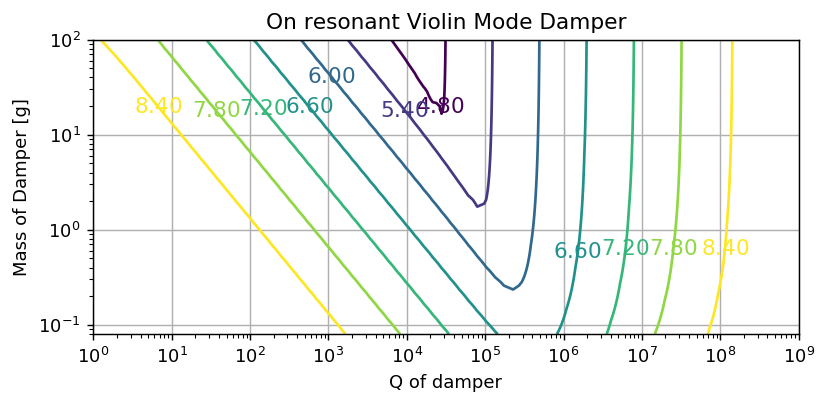

In [19]:
def contour_loss(lowest_loss = 1e-4, detune_F_D_Hz = 0):
    p_loss_D = logspaced(lowest_loss, 1, 80)
    p_M_D = logspaced(.8e-4, 1e-1, 80)
    #
    loss_D, M_D = np.meshgrid(p_loss_D, p_M_D)
    loss_arr = np.log10(eigQ(p_loss_D, M_D, detune_F_D_Hz))

    fig = pylab.figure()
    ax = fig.add_subplot(1,1,1)
    CP = ax.contour(
        1/(p_loss_D), 
        1e3 * (p_M_D), 
        loss_arr, 
        #levels = np.arange(0, 10),
    )
    labels = ax.clabel(
        CP, 
        inline = 0, 
        fontsize = 12,
        fmt = '$%1.2f$'
    )
    for l in labels:
        l.set_rotation(0)
    ax.grid(b = True)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Q of damper')
    ax.set_ylabel('Mass of Damper [g]')
    return locals()

#axB = contour_loss()
#axB['ax'].set_title('On resonant Violin Mode Damper')

axB = contour_loss(lowest_loss=1e-9)
axB['ax'].set_title('On resonant Violin Mode Damper')
axB['loss_arr']

array([[ 8.99999961,  8.99999961,  8.9999996 , ...,  8.99860723,
         8.99889315,  8.99910025],
       [ 8.9999996 ,  8.9999996 ,  8.9999996 , ...,  8.99847601,
         8.99878879,  8.99901553],
       [ 8.99999961,  8.9999996 ,  8.9999996 , ...,  8.99833223,
         8.99867471,  8.99892272],
       ..., 
       [ 8.99999963,  8.99999901,  8.9999982 , ...,  8.36210807,
         8.43693114,  8.50052667],
       [ 8.99999963,  8.99999895,  8.99999806, ...,  8.33168965,
         8.40816749,  8.4734184 ],
       [ 8.99999963,  8.99999888,  8.99999792, ...,  8.30068375,
         8.37873916,  8.44557985]])

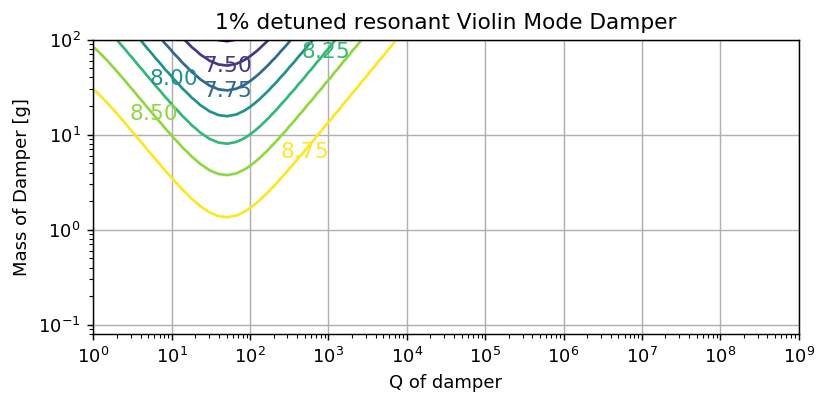

In [20]:
#axB = contour_loss(loss_eval)
#axB['ax'].set_title('1% detuned resonant Violin Mode Damper')
axB = contour_loss(lowest_loss = 1e-9, detune_F_D_Hz = .01 * 500)
axB['ax'].set_title('1% detuned resonant Violin Mode Damper')
axB['loss_arr']

array([[ 8.99999966,  8.99999955,  8.99999947, ...,  8.99862533,
         8.99890658,  8.99911038],
       [ 8.9999996 ,  8.99999954,  8.99999946, ...,  8.9984955 ,
         8.99880337,  8.99902639],
       [ 8.99999961,  8.99999953,  8.99999944, ...,  8.99835373,
         8.99869065,  8.99893436],
       ..., 
       [ 8.99999981,  8.99993817,  8.99985804, ...,  8.36642022,
         8.4407453 ,  8.50381343],
       [ 8.99999983,  8.99993239,  8.99984473, ...,  8.33608937,
         8.41207412,  8.47679769],
       [ 8.99999985,  8.99992606,  8.99983016, ...,  8.30516674,
         8.38273422,  8.44904831]])

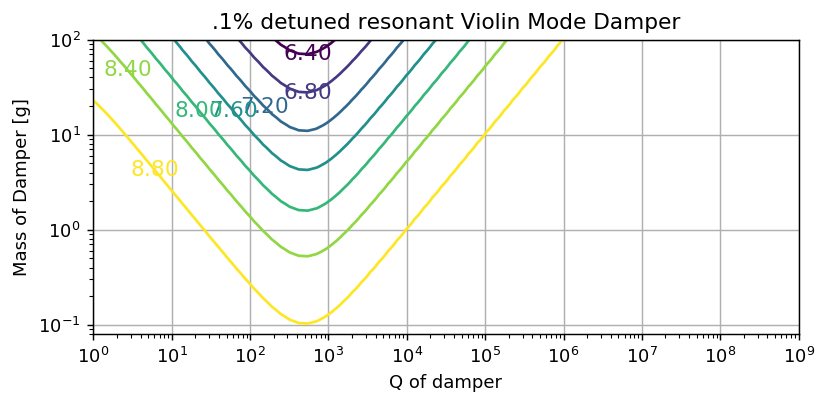

In [22]:
#axB = contour_loss(loss_eval)
#axB['ax'].set_title('1% detuned resonant Violin Mode Damper')
axB = contour_loss(lowest_loss = 1e-9, detune_F_D_Hz = .001 * 500)
axB['ax'].set_title('.1% detuned resonant Violin Mode Damper')
axB['loss_arr']